In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

### Funciones comunes

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
MAX_LENGTH = 10

In [4]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [5]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  # si tengo profundida de mi serie temporal, me quedo solamente con la 1ra.
  series = series[:,:,0]
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()


series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


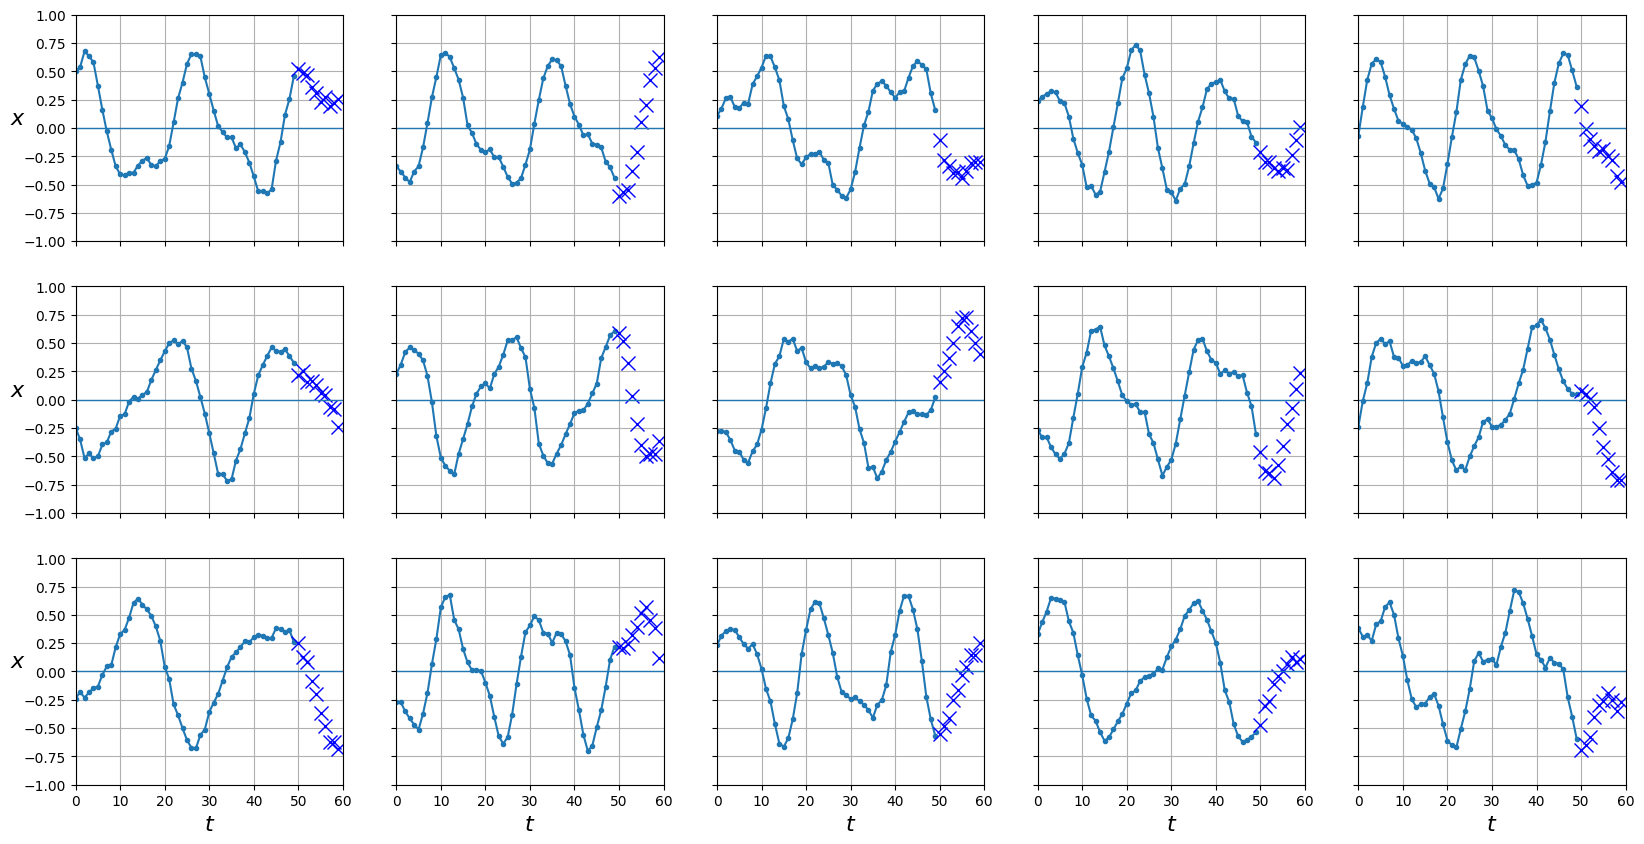

(1000, 10, 1)
(1000, 1)


In [6]:
# generamos unos nuevos datos para tener con qué comparar

n_steps = 50
n_future = 10

series = generate_time_series(10000, n_steps, n_future)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,0,:].shape)

In [7]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X

In [8]:
#
# tenemos q armar un nuevo dataloader que pase 10 valores a futuro

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader_10 = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}


In [9]:
# funciones de entrenamiento para el ENCODER-DECODER

def fit_enc_dec(model, dataloader, epochs=5, teacher_forcing = False, last_input = False):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    epoch_t_loss = []
    epoch_v_loss = []

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            # si deseo teacher_forcing debo pasarle el valor deseado
            # (el y verdadero que debe predecir para colocarlo como input
            # en el siguiente step)
            if teacher_forcing:
              target_tensor=y
            else:
              target_tensor=None
            # Esto es para que el decoder tenga como primer input el último
            # valor de la señal a predecir (para continuar con la "tendencia")
            if last_input:
              last_sample = X[:,-1,:]
            else:
              last_sample = None

            # con lo anterior configurado, hago el paso forrward
            y_hat = model(X, target_tensor=target_tensor, last_sample=last_sample)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            # guardo el loss
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")

        bar = tqdm(dataloader['eval'])
        model.eval()

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)

                # Esto es para que el decoder tenga como primer input el último
                # valor de la señal a predecir (para continuar con la "tendencia")
                if last_input:
                  last_sample = X[:,-1,:]
                else:
                  last_sample = None

                # En el validation, no se aplica teacher_forcing, por eso se
                # pasa como None.
                y_hat = model(X, target_tensor=None, last_sample=last_sample)
                loss = criterion(y_hat, y)
                # guardo el loss
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_v_loss.append(np.mean(eval_loss))
    return epoch_t_loss, epoch_v_loss


def predict_enc_dec(model, dataloader, reduced=0, last_input = False):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X[:,reduced:,:]
            X = X.to(device)

            # Esto es para que el decoder tenga como primer input el último
            # valor de la señal a predecir (para continuar con la "tendencia")
            if last_input:
              last_sample = X[:,-1,:]
            else:
              last_sample = None
            # En la predicción, no se aplica teacher_forcing, por eso se
            # pasa como None.
            pred = model(X, target_tensor=None, last_sample=last_sample)
            preds = torch.cat([preds, pred])
        return preds

In [10]:
# funciones de entrenamiento para el RNN simple o MLP

def fit_rnn(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    epoch_t_loss = []
    epoch_v_loss = []

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            y_hat = model(X)

            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")

        bar = tqdm(dataloader['eval'])
        model.eval()

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)


                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_v_loss.append(np.mean(eval_loss))
    return epoch_t_loss, epoch_v_loss

def predict_rnn(model, dataloader, reduced=0):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X[:,reduced:,:]
            X = X.to(device)

            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

### Modelos de NN a probar

In [11]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)

    return x[:,:,None]


In [12]:
class RNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=1, num_layers=1, n_out=1):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = torch.nn.Linear(in_features=hidden_size, out_features=n_out)
    # la fc la colocamos para cuando empleemos mas de 1 neurona hidden, ya que
    # tenemos que combinar todas las hidden de la salida de RNN en 1 solo
    # valor a predecir en el futuro. Para eso usaremos las FC.
    # ver en el forward cómo se leen los valores

  def forward(self, x):
    x, h = self.rnn(x)
    # ATENCION!!
    # La salida tentrá una dimensión del [batch x largo de señal x numero de hidden]
    # y a mi FC solo quiero pasarle la última predicción temporal, de todas sus hidden.
    # por eso, me quedo con:
    #       -- todo el batch
    #       -- solo la última predición temporal
    #       -- de todas sus hidden
    x = self.fc(x[:,-1:,:])
    y = x.permute(0,2,1)
    return y


In [13]:
class EncoderRNN(torch.nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)

    def forward(self, input):
        output, hidden = self.rnn(input)
        return output, hidden

In [14]:
class DecoderRNN(torch.nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=2):
        super(DecoderRNN, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.out = torch.nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None, last_sample=None):
        batch_size = encoder_outputs.size(0)
        # armo el 1er imput del decoder en función de si quiero colocar el ultimo
        # valor de la entrada del vector de datos
        if last_sample is None:
            decoder_input = torch.zeros(batch_size, 1, 1, dtype=torch.float32, device=device)
        else:
            decoder_input = last_sample[:,:,None]

        # traspaso el primer hidden que trae el encoder a la variables 'decoder_hidden'
        # por un tema de implementación
        decoder_hidden = encoder_hidden

        # preparo lista para almacenar los outputs
        decoder_outputs = []

        # ciclo interación para generar el largo de señal que deseo
        for i in range(MAX_LENGTH):
            # forward step del decoder de un solo paso
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            # almaceno los outputs
            decoder_outputs.append(decoder_output)

            # seccion de teacher forcing
            # si deseo teacher forcing (target_tensor existe)
            # coloco como siguiente input del decoder, el valor verdadero
            # caso contrario, utilizo la predicción

            if target_tensor is not None:
                # Teacher forcing: El proximo input es el valor deseado
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Sin teacher forcing: utilizo la predicción del modelo
                decoder_input = decoder_output.detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs, decoder_hidden

    def forward_step(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.out(output)
        return output, hidden

In [15]:
class EncoderDecoderWrapper(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, xb, target_tensor=None, last_sample=None):
        input_seq = xb
        encoder_output, encoder_hidden = self.encoder(input_seq)

        if target_tensor is not None:
          decoder_outputs, decoder_hidden = self.decoder(encoder_output, encoder_hidden, target_tensor=target_tensor, last_sample=last_sample)
        else:
          decoder_outputs, decoder_hidden = self.decoder(encoder_output, encoder_hidden, last_sample=last_sample)
        return decoder_outputs

### Entrenamiento ENC-DEC

In [32]:
N_EPOCHS = 10

In [33]:
enc = EncoderRNN(input_size=1, hidden_size=50, num_layers=2)
dec = DecoderRNN(input_size=1, hidden_size=50, output_size=1, num_layers=2)

In [34]:
enc_dec = EncoderDecoderWrapper(enc, dec)


In [35]:
train_loss, eval_loss = fit_enc_dec(enc_dec, dataloader_10, epochs=N_EPOCHS, teacher_forcing=False, last_input = True)

epoch numero:  0


valid_loss 0.04634: 100%|██████████| 32/32 [00:00<00:00, 74.10it/s]


epoch numero:  1


valid_loss 0.02706: 100%|██████████| 32/32 [00:00<00:00, 55.98it/s]


epoch numero:  2


valid_loss 0.02704: 100%|██████████| 32/32 [00:00<00:00, 65.59it/s]


epoch numero:  3


valid_loss 0.02129: 100%|██████████| 32/32 [00:00<00:00, 77.05it/s]


epoch numero:  4


valid_loss 0.01466: 100%|██████████| 32/32 [00:00<00:00, 82.29it/s]


epoch numero:  5


valid_loss 0.01168: 100%|██████████| 32/32 [00:00<00:00, 68.35it/s]


epoch numero:  6


valid_loss 0.01089: 100%|██████████| 32/32 [00:00<00:00, 80.96it/s]


epoch numero:  7


valid_loss 0.01019: 100%|██████████| 32/32 [00:00<00:00, 71.39it/s]


epoch numero:  8


valid_loss 0.01065: 100%|██████████| 32/32 [00:00<00:00, 62.29it/s]


epoch numero:  9


valid_loss 0.01648: 100%|██████████| 32/32 [00:00<00:00, 55.01it/s]


epoch numero:  10


valid_loss 0.00945: 100%|██████████| 32/32 [00:00<00:00, 77.20it/s]


In [36]:
t_train_loss = torch.Tensor(train_loss)
t_eval_loss = torch.Tensor(eval_loss)

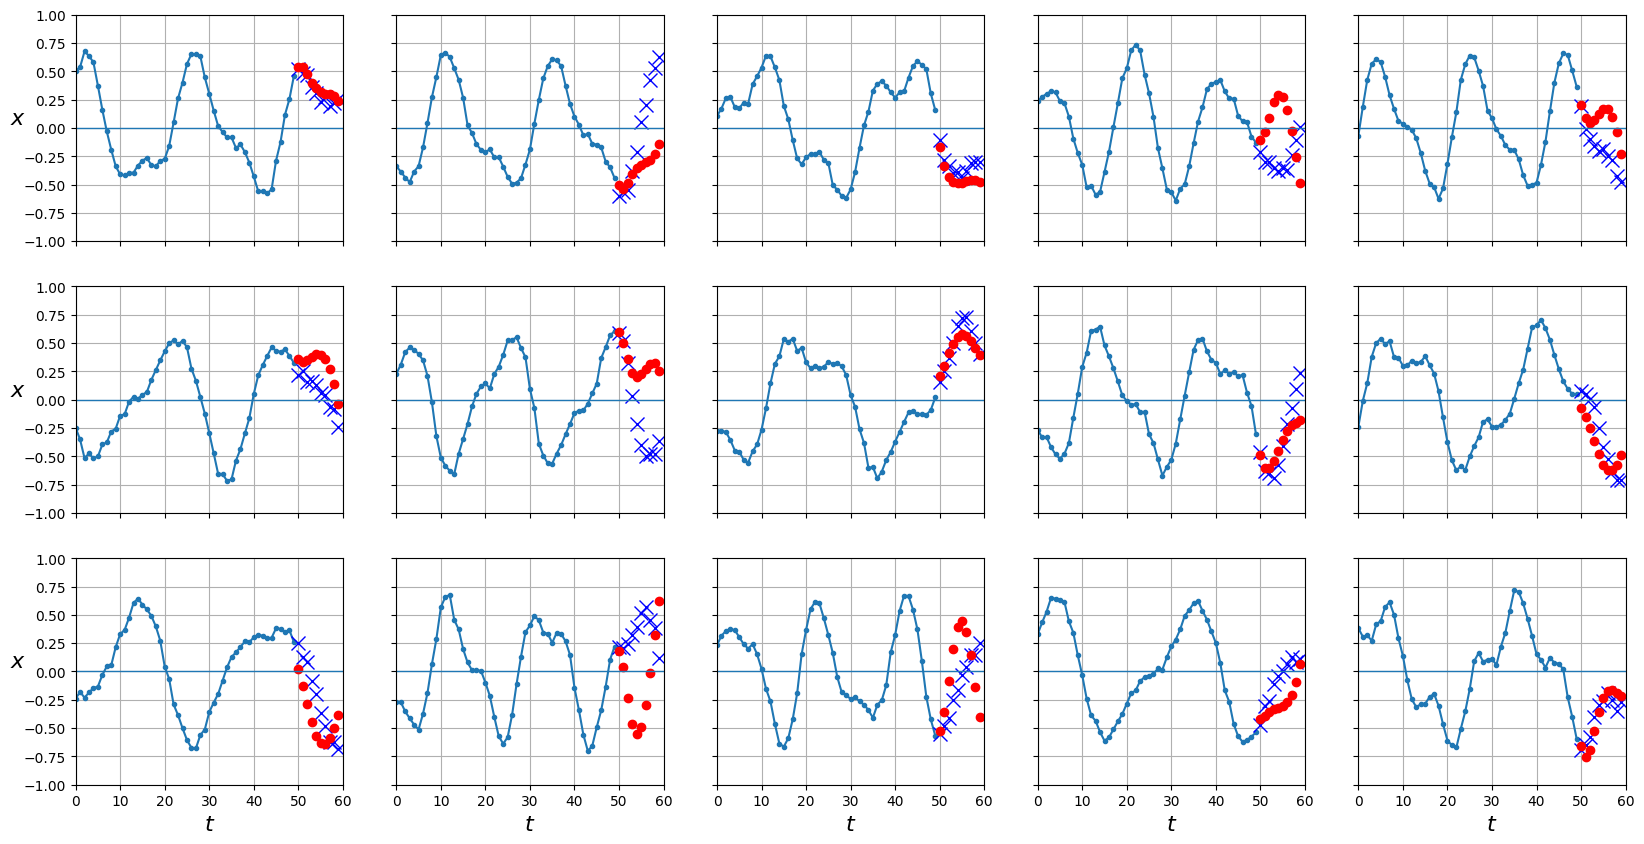

Error cuadratico medio de la estimación final: 


0.090082884

In [48]:
y_pred = predict_enc_dec(enc_dec, dataloader_10['test'], reduced=30, last_input = True)
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('Error cuadratico medio de la estimación final: ')
mean_squared_error(y_test.squeeze(), y_pred.cpu().numpy().squeeze())

# PROBAR MODIFICAR EL ARGUMENTO REDUCED!!

### Entrenamiento RNN colocano n_out = 10

In [38]:
# creamos un nuevo objeto, ahora con n_out de la FC igual a 10
# (queremos ver 10 valores a futuro)

rnn_10 = RNN(input_size=1, hidden_size=50, num_layers=2, n_out=10)
train_loss, eval_loss = fit_rnn(rnn_10, dataloader_10, epochs = N_EPOCHS)

epoch numero:  0


valid_loss 0.03869: 100%|██████████| 32/32 [00:00<00:00, 101.97it/s]


epoch numero:  1


valid_loss 0.03161: 100%|██████████| 32/32 [00:00<00:00, 95.22it/s]


epoch numero:  2


valid_loss 0.02750: 100%|██████████| 32/32 [00:00<00:00, 102.28it/s]


epoch numero:  3


valid_loss 0.01612: 100%|██████████| 32/32 [00:00<00:00, 94.69it/s]


epoch numero:  4


valid_loss 0.01204: 100%|██████████| 32/32 [00:00<00:00, 80.53it/s]


epoch numero:  5


valid_loss 0.01282: 100%|██████████| 32/32 [00:00<00:00, 104.96it/s]


epoch numero:  6


valid_loss 0.01067: 100%|██████████| 32/32 [00:00<00:00, 92.88it/s]


epoch numero:  7


valid_loss 0.01000: 100%|██████████| 32/32 [00:00<00:00, 90.06it/s]


epoch numero:  8


valid_loss 0.01039: 100%|██████████| 32/32 [00:00<00:00, 73.05it/s]


epoch numero:  9


valid_loss 0.01050: 100%|██████████| 32/32 [00:00<00:00, 94.98it/s]


epoch numero:  10


valid_loss 0.01091: 100%|██████████| 32/32 [00:00<00:00, 86.98it/s]


In [39]:
t_train_loss = torch.cat((t_train_loss, torch.Tensor(train_loss)),0)
t_eval_loss = torch.cat((t_eval_loss, torch.Tensor(eval_loss)),0)

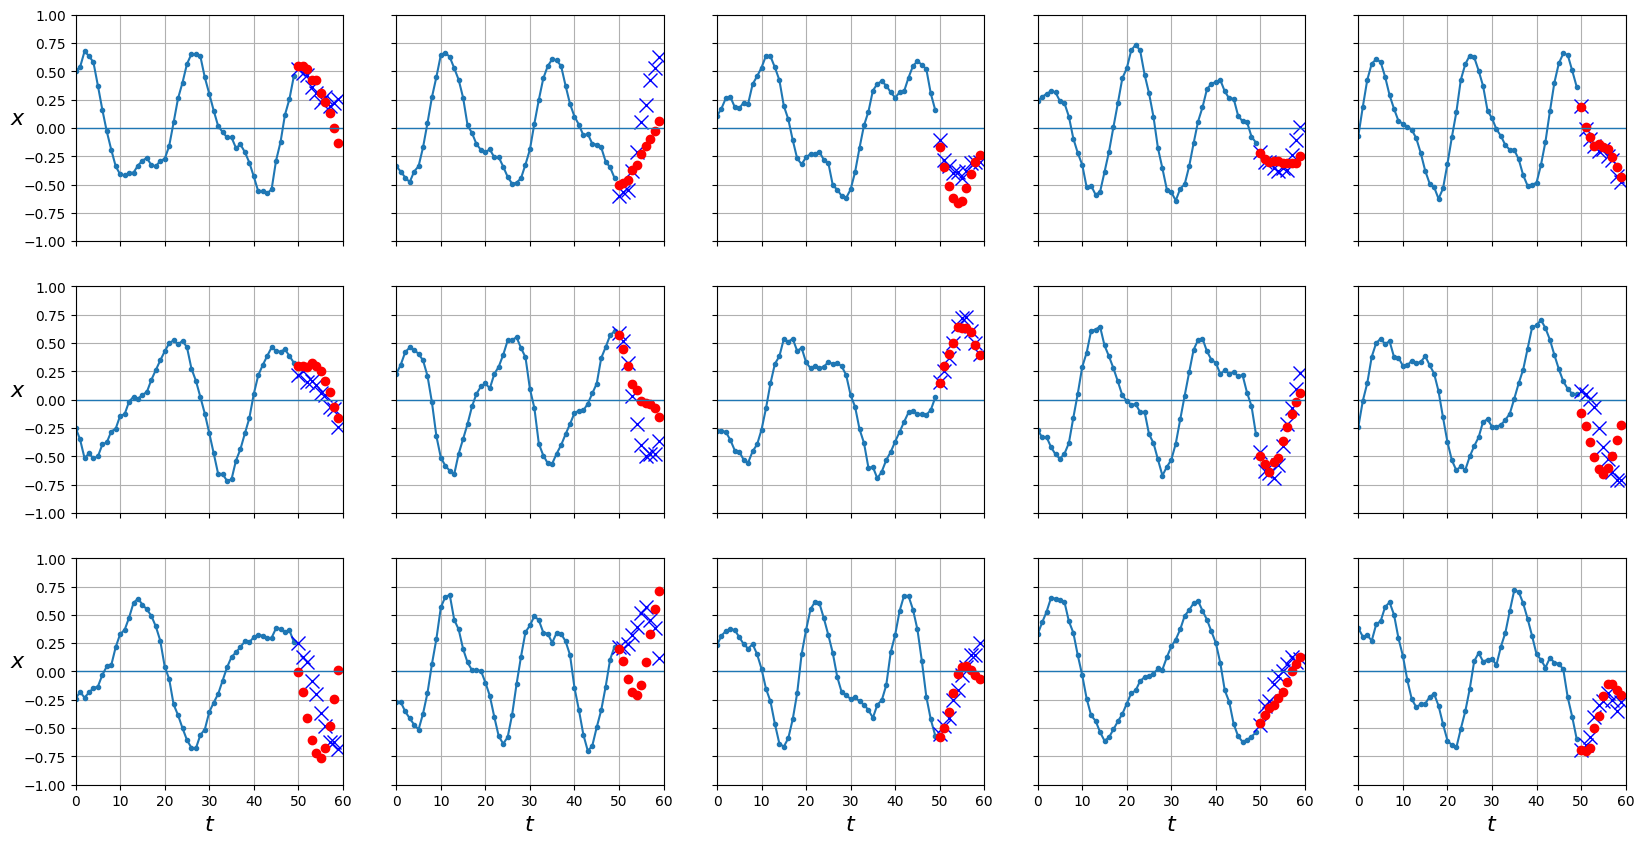

Error cuadratico medio de la estimación final: 


0.050644964

In [49]:
y_pred = predict_rnn(rnn_10, dataloader_10['test'], reduced=30)
plot_series(X_test, y_test, y_pred.cpu().numpy())

print('Error cuadratico medio de la estimación final: ')
mean_squared_error(y_test.squeeze(), y_pred.cpu().numpy().squeeze())

# PROBAR MODIFICAR EL ARGUMENTO REDUCED!!

### Entrenamiento MLP que predice 10 muestras a futuro

In [41]:
# lo comparamos en el mlp pero que prediga 10 valores a futuro
# lo redefino para tener N out = 10
mlp_10 = MLP(n_steps, n_future)

# entreno de nuevo el mlp con los nuevos datos y graficamos

train_loss, eval_loss = fit_rnn(mlp_10, dataloader_10, epochs=N_EPOCHS)



epoch numero:  0


valid_loss 0.06590: 100%|██████████| 32/32 [00:00<00:00, 255.63it/s]


epoch numero:  1


valid_loss 0.05015: 100%|██████████| 32/32 [00:00<00:00, 244.16it/s]


epoch numero:  2


valid_loss 0.04223: 100%|██████████| 32/32 [00:00<00:00, 216.51it/s]


epoch numero:  3


valid_loss 0.03755: 100%|██████████| 32/32 [00:00<00:00, 236.77it/s]


epoch numero:  4


valid_loss 0.03418: 100%|██████████| 32/32 [00:00<00:00, 154.04it/s]


epoch numero:  5


valid_loss 0.03175: 100%|██████████| 32/32 [00:00<00:00, 189.28it/s]


epoch numero:  6


valid_loss 0.02986: 100%|██████████| 32/32 [00:00<00:00, 198.62it/s]


epoch numero:  7


valid_loss 0.02830: 100%|██████████| 32/32 [00:00<00:00, 188.83it/s]


epoch numero:  8


valid_loss 0.02707: 100%|██████████| 32/32 [00:00<00:00, 217.42it/s]


epoch numero:  9


valid_loss 0.02613: 100%|██████████| 32/32 [00:00<00:00, 245.37it/s]


epoch numero:  10


valid_loss 0.02514: 100%|██████████| 32/32 [00:00<00:00, 208.12it/s]


In [42]:
t_train_loss = torch.cat((t_train_loss, torch.Tensor(train_loss)),0)
t_eval_loss = torch.cat((t_eval_loss, torch.Tensor(eval_loss)),0)

In [43]:
t_train_loss

tensor([0.0778, 0.0341, 0.0279, 0.0227, 0.0197, 0.0163, 0.0133, 0.0118, 0.0123,
        0.0122, 0.0114, 0.0671, 0.0339, 0.0276, 0.0189, 0.0140, 0.0124, 0.0114,
        0.0115, 0.0101, 0.0102, 0.0097, 0.0934, 0.0548, 0.0438, 0.0378, 0.0340,
        0.0313, 0.0293, 0.0278, 0.0265, 0.0255, 0.0247])

In [44]:
t_train_loss = t_train_loss.reshape(3,N_EPOCHS+1)
t_eval_loss = t_eval_loss.reshape(3,N_EPOCHS+1)

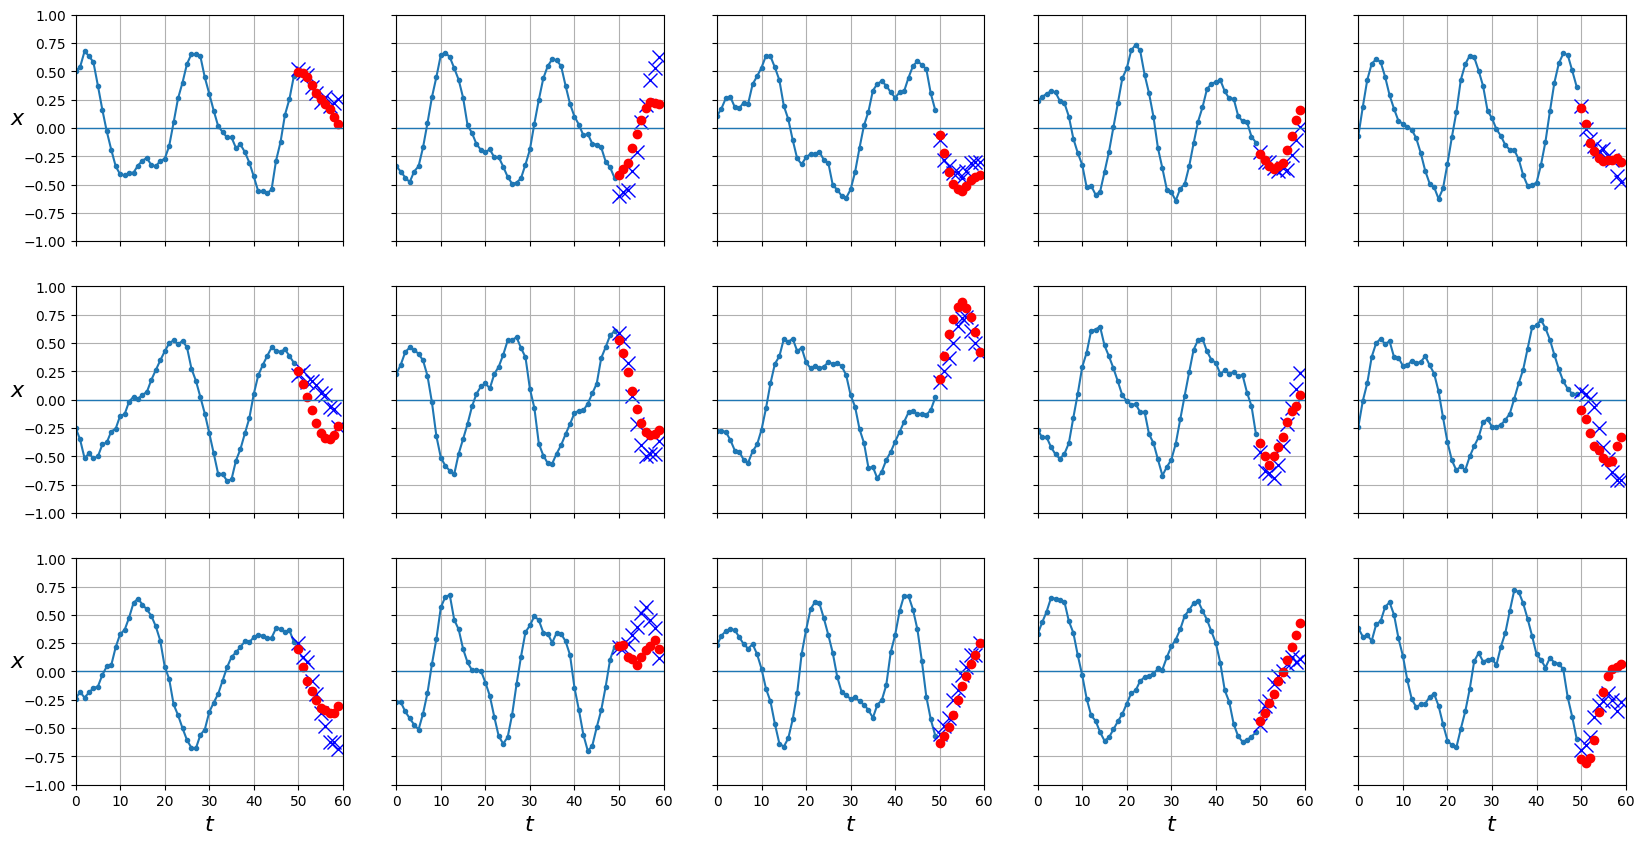

Error cuadratico medio de la estimación final: 


0.02469893

In [45]:
# ploteo y veo el error total
y_pred = predict_rnn(mlp_10, dataloader_10['test'], reduced=0)
plot_series(X_test, y_test, y_pred)

print('Error cuadratico medio de la estimación final: ')
mean_squared_error(y_test.squeeze(), y_pred.cpu().numpy().squeeze())

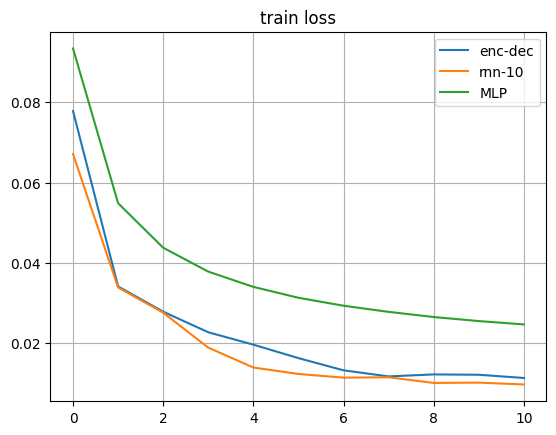

In [46]:
plt.figure()
plt.plot(t_train_loss.T)
plt.title('train loss')
plt.legend(['enc-dec', 'rnn-10', 'MLP'])
plt.grid()

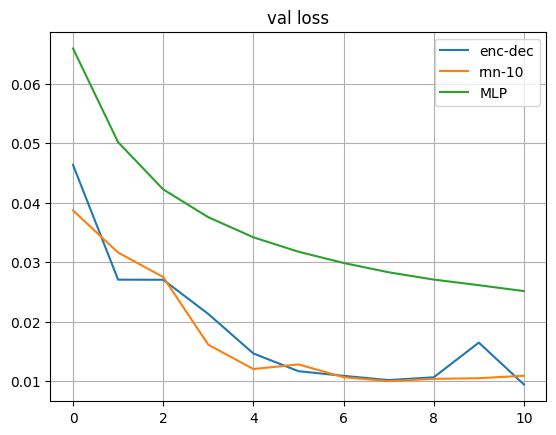

In [47]:
plt.figure()
plt.plot(t_eval_loss.T)
plt.title('val loss')
plt.legend(['enc-dec', 'rnn-10', 'MLP'])
plt.grid()